In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
train_data_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
valid_data_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'
test_data_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Test'

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

In [4]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(224, 224),
                                                    batch_size=32, class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(valid_data_dir, target_size=(224, 224),
                                                    batch_size=32, class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(224, 224),
                                                  batch_size=32, class_mode='binary', shuffle=False)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [6]:
base_model = tf.keras.applications.EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [7]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [8]:
model = Model(inputs=base_model.input, outputs=predictions)

# ✅ Compile Model
model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.00005), metrics=['accuracy'])

# ✅ Train Model
history = model.fit(train_generator, epochs=5, validation_data=valid_generator)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 3066s 666ms/step - accuracy: 0.8271 - loss: 0.3983 - val_accuracy: 0.9540 - val_loss: 0.1189
Epoch 2/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1733s 395ms/step - accuracy: 0.9609 - loss: 0.1031 - val_accuracy: 0.9660 - val_loss: 0.0884
Epoch 3/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1709s 390ms/step - accuracy: 0.9767 - loss: 0.0647 - val_accuracy: 0.9681 - val_loss: 0.0835
Epoch 4/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1698s 387ms/step - accuracy: 0.9805 - loss: 0.0519 - val_accuracy: 0.9791 - val_loss: 0.0600
Epoch 5/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1579s 360ms/step - accuracy: 0.9826 - loss: 0.0463 - val_accuracy: 0.9784 - val_loss: 0.0617


In [9]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

341/341 ━━━━━━━━━━━━━━━━━━━━ 85s 249ms/step - accuracy: 0.9584 - loss: 0.1090
Test Accuracy: 91.66%


341/341 ━━━━━━━━━━━━━━━━━━━━ 35s 80ms/step


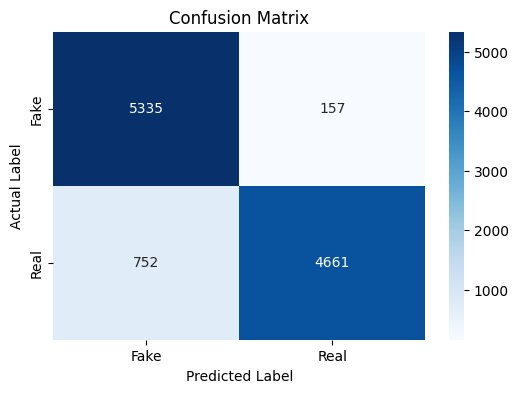

              precision    recall  f1-score   support

        Fake       0.88      0.97      0.92      5492
        Real       0.97      0.86      0.91      5413

    accuracy                           0.92     10905
   macro avg       0.92      0.92      0.92     10905
weighted avg       0.92      0.92      0.92     10905



In [10]:
test_generator.reset()
Y_pred = model.predict(test_generator)
Y_pred = (Y_pred > 0.5).astype(int)
Y_true = test_generator.classes

conf_matrix = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(Y_true, Y_pred, target_names=['Fake', 'Real']))

In [11]:
model.save('deepfake_detector.h5')

In [12]:
def calculate_psnr(img1, img2):
    """Calculate Peak Signal-to-Noise Ratio (PSNR)"""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100  # Maximum PSNR
    PIXEL_MAX = 255.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr

In [13]:
image_path_real = "/kaggle/input/deepfake-and-real-images/Dataset/Test/Real/real_1002.jpg"
image_path_fake = "/kaggle/input/deepfake-and-real-images/Dataset/Test/Fake/fake_100.jpg"

In [14]:
img_real = cv2.imread(image_path_real, cv2.IMREAD_GRAYSCALE)
img_fake = cv2.imread(image_path_fake, cv2.IMREAD_GRAYSCALE)
img_real = cv2.resize(img_real, (224, 224))
img_fake = cv2.resize(img_fake, (224, 224))

In [15]:
psnr_value = calculate_psnr(img_real, img_fake)
print(f"PSNR between real and fake image: {psnr_value:.2f} dB")

PSNR between real and fake image: 27.92 dB


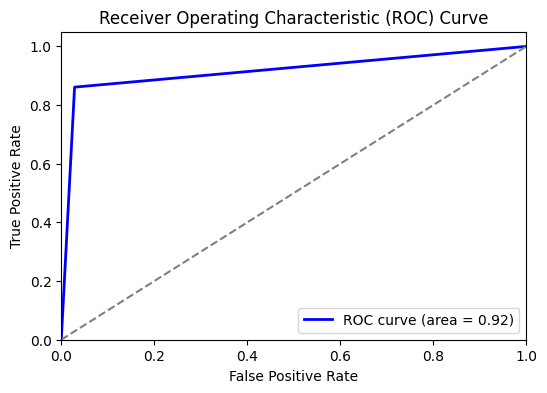

In [16]:
fpr, tpr, _ = roc_curve(Y_true, Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
from tensorflow.keras.preprocessing import image

def test_single_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)[0][0]
    label = 'Real' if prediction > 0.5 else 'Fake'
    print(f"Predicted Label: {label} (Confidence: {prediction:.2f})")

In [18]:
image_path = "/kaggle/input/deepfake-and-real-images/Dataset/Test/Fake/fake_10.jpg"
test_single_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted Label: Fake (Confidence: 0.00)
